# cvxpy

In [20]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels
import cvxpy as cp
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import Normalizer, MaxAbsScaler

$$
\begin{align}
%     dual function
    \min_{\beta, \eta} \mathcal{D}(\beta, \eta) = &
%     -1\2 omega^2
    \frac{1}{2}\sum_{k, l = 1}^N \beta_k \beta_l K(x_l, x_k)  
%     e(a + a*)
+ \frac{\epsilon}{100} \sum_{k=1}^N |\beta_k|y_k
%     y_k(a - a*)
- \sum_{k=1}^N y_k \beta_k \\
\text{S. t. } & \sum_{k=1}^N  \beta_k = 0 & (9)\\
& 0 \leq |\beta_k|  \leq \frac{100}{y_k}C
\end{align}
$$

In [21]:
kernel = "rbf"

In [22]:
y1 =pd.read_excel(r'Data1.xlsx').set_index("fecha").loc["2007-01-01":"2020-03-30"]
X1 = pd.read_csv("X.csv")

X = X1.drop(["fecha"], axis = 1).to_numpy(); y = y1.to_numpy()

# scaler1 = MaxAbsScaler(); scaler1.fit(y); y = scaler1transform(y)

X, X_test, y, y_test = train_test_split(X, y, test_size = 40, shuffle = False)

scaler = MaxAbsScaler(); scaler.fit(X); X = scaler.transform(X)
X_test = scaler.transform(X_test)

scaler1 = MaxAbsScaler(); scaler1.fit(y); y = scaler1.transform(y).reshape(-1)
y_test = scaler1.transform(y_test).reshape(-1)

Parameters to be defined: $\epsilon$ and $C$

In [23]:
ydim = y.shape[0]
epsilon = 5 # margin max
C = 0.5 # alphas constraint
onev = np.ones((ydim,1))
error = 1E-5 # vector support 

In [24]:
beta = cp.Variable((ydim,1)) # variable to be optimized

In [25]:
X.shape

(4798, 51)

In [26]:
K = pairwise_kernels(X, X, metric = kernel)

In [27]:
Ev = (y*epsilon)/100 

In [28]:
objective = cp.Minimize((1/2)*cp.quad_form(beta, K) + Ev.T @ cp.abs(beta) - y.T @ beta)

In [29]:
A = onev.T
b = 0
G = np.concatenate((np.identity(ydim), -np.identity(ydim)))
h_ = np.concatenate((100*C*np.ones(ydim)/y, 100*C*np.ones(ydim)/y)); 
h = h_.reshape(-1, 1)

In [30]:
constraints = [A @ beta == b, G @ beta <= h]

In [31]:
# adaptive_rho = False

In [32]:
prob = cp.Problem(objective,constraints)
result = prob.solve()

In [33]:
beta.value.max(), np.abs(beta.value).min()

(91.86583674552584, 1.226218374052853e-08)

In [34]:
beta_1 = np.array(beta.value)
indx = np.abs(beta_1) > error
beta_sv = beta_1[indx]
x_sv = X[indx[:,0],:]
y_sv = y[indx[:,0]]


$$
b = \left\{
\begin{array}{ll}
& y_k\left[1 - \frac{\epsilon}{100}\right] - \omega \phi(x_k) & 0 < \beta < 100\frac{C}{y_k}\\
\\
& y_k\left[1 + \frac{\epsilon}{100}\right] - \omega\phi(x_k) & -100\frac{C}{y_k} < \beta < 0\\
\end{array}
\right.
$$

$$
\phi^T\omega =  \beta^T K
$$

In [35]:
# new kernel and custom b constant
k_sv = pairwise_kernels(x_sv, x_sv, metric = kernel)
cons = np.where(beta_sv >= 0, 1 - epsilon/100, 1 + epsilon/100)

In [36]:
# omega and b
w_phi = beta_sv @ k_sv
b = np.mean((y_sv*cons - w_phi))

In [37]:
# predict
k_test = pairwise_kernels(x_sv, X_test, metric = kernel)
w_phi_test = beta_sv @ k_test

In [38]:
y_pred = w_phi_test + b

In [39]:
# RBF X filtered

2.504812535402213


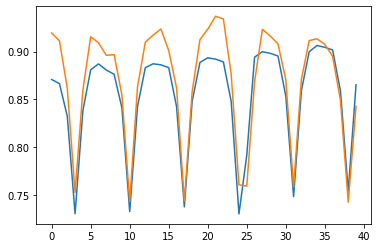

In [40]:
print(np.mean(np.abs((y_pred - y_test))/y_test)*100)

plt.plot(y_pred)
plt.plot(y_test)

In [ ]:
# linear

2.4916754294257237


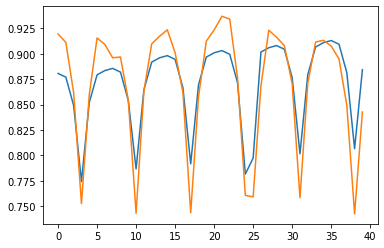

In [19]:
print(np.mean(np.abs((y_pred - y_test))/y_test)*100)

plt.plot(y_pred)
plt.plot(y_test)

In [ ]:
# RBF

In [153]:
np.mean(np.abs((y_pred - y_test))/y_test)*100

2.2652287537551685

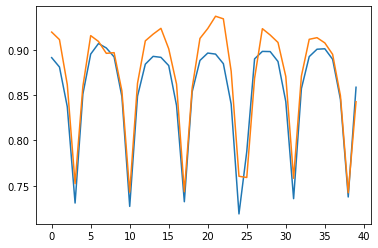

In [154]:
plt.plot(y_pred)
plt.plot(y_test)